# Problem Statement

* The central focus of our undertaking is the creation of advanced trading strategies tailored specifically to the **BTC/USDT** cryptocurrency market. Our main emphasis was on cutting the drawdowns, and at the same time trying not to compromise on the returns

# Data Acquisition

## Importing the libraries

In [129]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4473    0  4473    0     0  14796      0 --:--:-- --:--:-- --:--:-- 14811
100  517k  100  517k    0     0   727k      0 --:--:-- --:--:-- --:--:-- 9951k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4485    0  4485    0     0  15057      0 --:--:-- --:--:-- --:--:-- 15101
100  392k  100  392k    0     0   609k      0 --:--:-- --:--:-- --:--:--  609k


In [131]:
!pip install pandas_market_calendars
!pip install quantstats

In [132]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from prettytable import PrettyTable
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the data

In [133]:
data = pd.read_csv('daily_data.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# Data visualisation

## Closing prices

In [134]:
import plotly.graph_objects as go
fig = go.Figure()
# Plotting stock price
fig.add_trace(go.Scatter(x=data['datetime'], y=data['close'], mode='lines', name='Stock Price'))
# Adding layout details
fig.update_layout(
    title='Stock Closing Price Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Closing Price'),
    template='plotly_dark'
)
# Display the plot
fig.show()

## Closing prices per year

In [135]:
import plotly.express as px

data['year'] = data['datetime'].dt.year

# Create an interactive box plot using Plotly Express with a colorful palette
fig = px.box(data, x='year', y='close', color='year', title='Closing Stock Prices by Year',
             labels={'year': 'Year', 'close': 'Closing Stock Price'})

# Customize the layout if needed
fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Closing Stock Price'),
    showlegend=False,  # Set to True if you want to display legend
    template='plotly_dark'

)

# Show the plot
fig.show()

## Correlation between OHLC prices

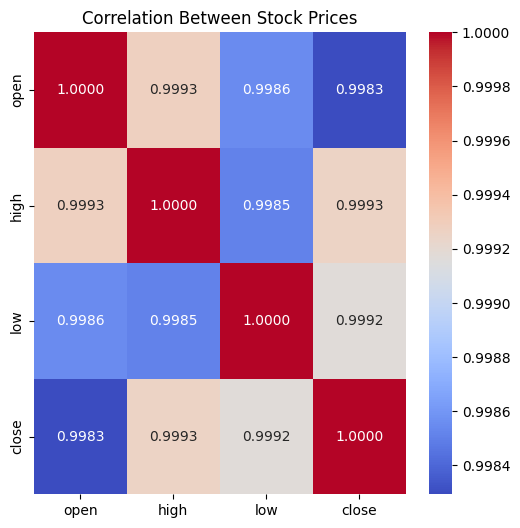

In [136]:
corr = data[['open', 'high', 'low', 'close']].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, fmt=".4f", cmap='coolwarm')
plt.title('Correlation Between Stock Prices')
plt.show()

## Distribution of closing stock price

In [137]:
import plotly.express as px
import pandas as pd

# Assuming df is your DataFrame containing the 'close' column

fig = px.histogram(data, x='close', nbins=30, marginal='rug', title='Distribution of Closing Stock Price')
fig.update_layout(xaxis_title='Closing Stock Price', yaxis_title='Frequency', bargap=0.05, template='plotly_dark')
fig.show()

##Line chart of log of daily returns

In [138]:
import plotly.graph_objects as go

def calculate_log_returns(close_prices):
    num_days = 1
    log_returns = []

    for i in range(len(close_prices) - 1):
        log_returns.append(math.log(close_prices.iloc[i + 1]) - math.log(close_prices.iloc[i]))

    dates = close_prices.index[0:len(close_prices) - 1]

    # Create a Plotly figure
    fig = go.Figure()

    # Add a line trace for log returns with a different color
    fig.add_trace(go.Scatter(x=dates, y=log_returns, mode='lines', name='Log Returns'))

    # Update layout for better visualization
    fig.update_layout(
        title='Stock Log Returns Over Time',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Log Returns'),
        showlegend=True,
        template='plotly_dark'
    )

    # Show the plot
    fig.show()

    return pd.Series(log_returns)

# Assuming df is your DataFrame with a 'close' column
returns = calculate_log_returns(data['close'])

## Candlestick plot with volume bars

In [139]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7, 0.3])

candlestick = go.Candlestick(x=data['datetime'],
                             open=data['open'],
                             high=data['high'],
                             low=data['low'],
                             close=data['close'],
                             name='Candlesticks')

fig.add_trace(candlestick, row=1, col=1)

volume_bars = go.Bar(x=data['datetime'], y=data['volume'], name='Volume Bars', marker=dict(color='blue'))

fig.add_trace(volume_bars, row=2, col=1)

fig.update_layout(title='Candlestick Chart with Volume Bars',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  template='plotly_dark')
fig.show()

## Plot of volume bars

In [140]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(x=data.index, y=data['volume'], name='Volume', marker=dict(color='maroon', opacity=1)))

fig.update_layout(title='Volume Bars',
                  xaxis_title='Date',
                  yaxis_title='Volume'
                  )

fig.show()

# Statistical Testing for the given OHLC historical data

## ADF Test

We first conduct ADF test to find out the stationarity of the data

In [141]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if  result[1]>0.05:
      print('p-value>0.05 : data is non-stationary.')
    else:
      print('p-value<0.05 : data is stationary')

adf_test(data['close']) #Before Differencing

ADF Statistic: -0.844041
p-value: 0.805842
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value>0.05 : data is non-stationary.


In [142]:
df_trans=data.close.diff().dropna()
adf_test(df_trans) #After Differencing

ADF Statistic: -10.900047
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
p-value<0.05 : data is stationary


## 4 Moments

Following is the code to calculate the four moments of the price series:
*   Mean
*   Variance
*   Skewness
*   Kurtosis

In [143]:
def analyze_stock_performance(stock_data):
    stock_data = stock_data.iloc[2:]
    mean_returns = []
    variance_returns = []
    skewness_returns = []
    kurtosis_returns = []

    for i in range(1, len(stock_data) + 1):
        from scipy.stats import kurtosis
        from scipy.stats import skew

        daily_returns = stock_data.iloc[2:2+i].pct_change().dropna()
        mean_returns.append(daily_returns.mean())
        variance_returns.append(daily_returns.var())
        skewness_returns.append(skew(daily_returns))
        kurtosis_returns.append(kurtosis(daily_returns))

    return mean_returns, variance_returns, skewness_returns, kurtosis_returns

In [144]:
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots

mean, variance, skew, kurtosis = analyze_stock_performance(data['close'])

# Create a subplot with 2 rows and 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=["Mean (Moment 1)", "Variance (Moment 2)", "Skew (Moment 3)", "Kurtosis (Moment 4)"])

# Plot Mean
fig.add_trace(go.Scatter(x=list(range(1, len(mean) + 1)), y=mean, mode='lines', name='Mean'), row=1, col=1)

# Plot Variance
fig.add_trace(go.Scatter(x=list(range(1, len(variance) + 1)), y=variance, mode='lines', name='Variance'), row=1, col=2)

# Plot Skew
fig.add_trace(go.Scatter(x=list(range(1, len(skew) + 1)), y=skew, mode='lines', name='Skew'), row=2, col=1)

# Plot Kurtosis
fig.add_trace(go.Scatter(x=list(range(1, len(kurtosis) + 1)), y=kurtosis, mode='lines', name='Kurtosis'), row=2, col=2)

# Update layout
fig.update_layout(height=600, width=800, title_text="Statistical Moments Analysis", showlegend=True)

# Update x and y-axis labels
fig.update_xaxes(title_text="Sample Size", row=1, col=1)
fig.update_xaxes(title_text="Sample Size", row=1, col=2)
fig.update_xaxes(title_text="Sample Size", row=2, col=1)
fig.update_xaxes(title_text="Sample Size", row=2, col=2)

fig.update_yaxes(title_text="Moment", row=1, col=1)
fig.update_yaxes(title_text="Moment", row=1, col=2)
fig.update_yaxes(title_text="Moment", row=2, col=1)
fig.update_yaxes(title_text="Moment", row=2, col=2)

# Show the plot
fig.show()

## Autocorrelation function

This code is used to calculate autocorrelation in the price series upon varying lags

In [145]:
autocorrelation_values = []
max_lag = 100

for lag in range(1, max_lag):
    autocorr = np.correlate(returns[:-lag], returns[lag:]) / (np.std(returns[:-lag]) * np.std(returns[lag:]))
    autocorrelation_values.append((lag, autocorr[0]))

autocorrelation_df = pd.DataFrame(autocorrelation_values, columns=['Lag', 'Autocorrelation'])

In [146]:
autocorrelation_df.head()

,Lag,Autocorrelation
0,1,-46.413637
1,2,-34.708333
2,3,32.799333
3,4,24.565386
4,5,98.243063


In [147]:
import plotly.express as px

fig = px.line(autocorrelation_df, x='Lag', y='Autocorrelation', labels={'Lag': 'Lag', 'Autocorrelation': 'Autocorrelation'})
fig.update_layout(title='Plot of Lag vs. Autocorrelation', xaxis_title='Lag', yaxis_title='Autocorrelation')

# Show the plot
fig.show()

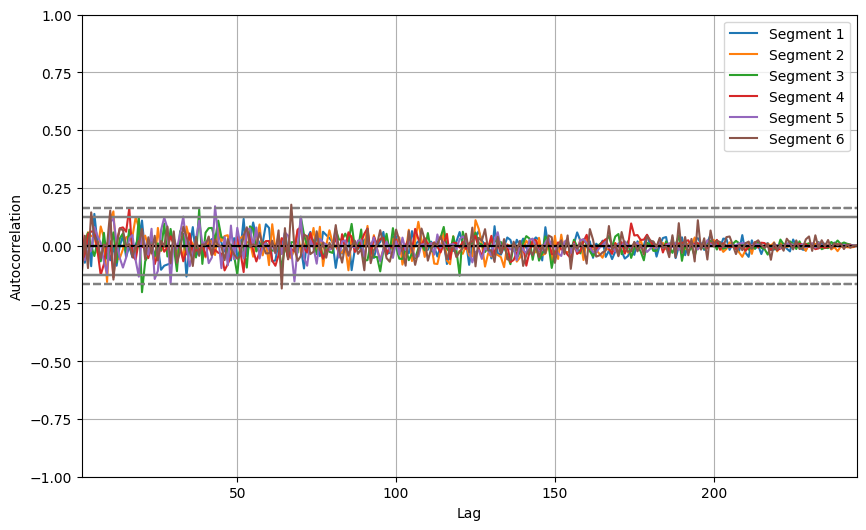

In [148]:
l = len(data)
plt.figure(figsize=(10,6))
x1 = pd.plotting.autocorrelation_plot(returns[0:l//6],label=('Segment 1'))
x2 = pd.plotting.autocorrelation_plot(returns[l//6:2*l//6],label=('Segment 2'))
x3 = pd.plotting.autocorrelation_plot(returns[2*l//6:3*l//6],label=('Segment 3'))
x4 = pd.plotting.autocorrelation_plot(returns[3*l//6:4*l//6],label=('Segment 4'))
x5 = pd.plotting.autocorrelation_plot(returns[4*l//6:5*l//6],label=('Segment 5'))
x6 = pd.plotting.autocorrelation_plot(returns[5*l//6:l],label=('Segment 6'))

plt.grid()
plt.legend(loc='upper right')

plt.show()

# Strategy

## Relative Strength Index

* RSI - the relative strength index compares a security's strength on days when prices go up to its strength on days when prices go down.



$$
\text{RSI} = 100 - \frac{100}{1 + \frac{(\text{Previous Average Loss} \times 13) + \text{Current Loss}}{(\text{Previous Average Gain} \times 13) + \text{Current Gain}}}
$$
* If we take a lookback period of 14 days.

**Input parameters : array of closing price of stock, lookback period**




In [149]:
# RSI calculation using talib library
data['rsi']=ta.RSI(data['close'],6)

In [150]:
import plotly.graph_objects as go
trace_rsi = go.Scatter(x=data.index, y=data['rsi'], mode='lines', name='RSI', line=dict(color='#316395'))

# Create layout
layout = go.Layout(title='Relative Strength Index (RSI) Over Time',
                   xaxis=dict(title='Time'),
                   yaxis=dict(title='RSI'),
                   showlegend=True)

# Add horizontal lines at RSI 80 and 20
layout.shapes = [
    dict(type='line', x0=data.index[0], x1=data.index[-1], y0=80, y1=80, line=dict(color='rgb(237,100,90)', width=2, dash='dash')),
    dict(type='line', x0=data.index[0], x1=data.index[-1], y0=20, y1=20, line=dict(color='rgb(237,100,90)', width=2, dash='dash'))
]

# Create figure and add traces
fig = go.Figure(data=[trace_rsi], layout=layout)

# Show the figure
fig.show()

## Average True Range

* **True Range**: The true range of the day is taken as the greatest of the following: current high less the current low; the absolute value of the current high less the previous close; and the absolute value of the current low less the previous close.

* **Average True Range:** The Average True Range is a moving average,  using 12 days, of the true ranges.

* **Input parameters: ohlc data**

In [151]:
# Setting the period for the Average True Range (ATR) calculation
period = 14

data['TR'] = None

for i in range(1, len(data)):
    # Calculate the True Range (TR) for the current row
    high_low_range = abs(data['high'][i] - data['low'][i])  # High-Low Range
    high_prev_close_range = abs(data['high'][i] - data['close'][i - 1])  # High-Previous Close Range
    low_prev_close_range = abs(data['low'][i] - data['close'][i - 1])  # Low-Previous Close Range

    # Assign the maximum value of the three ranges to the 'TR' column for the current row
    data['TR'][i] = max(high_low_range, high_prev_close_range, low_prev_close_range)

# The 'TR' column now contains the True Range values calculated for each row
data['atr'] = None

# The ATR is a measure of market volatility, computed as the rolling mean of the True Range (TR)
data['atr'] = data['TR'].rolling(window=period).mean()

In [152]:
import plotly.graph_objects as go
import pandas as pd

# Create a trace for ATR
trace_atr = go.Scatter(x=data.index, y=data['atr'], mode='lines', name='ATR', line=dict(color='rgb(175, 100, 88)'))

# Create layout
layout = go.Layout(title='Average True Range (ATR) Over Time',
                   xaxis=dict(title='Time'),
                   yaxis=dict(title='ATR'),
                   showlegend=True)

# Create figure and add traces
fig = go.Figure(data=[trace_atr], layout=layout)

# Show the figure
fig.show()


## MACD

* Moving average convergence/divergence (MACD, or MAC-D): It shows the relationship between two exponential moving averages (EMAs) of a security's price. The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA.

* Input Parameters- An array containing the closing price of thes stock, the lookback periods of the short term moving average, the lookback periods of the long term moving average and the lookback period for calculating the signal line.

In [153]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short-term and long-term exponential moving averages
    data['ShortEMA'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['LongEMA'] = data['close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    data['MACD'] = data['ShortEMA'] - data['LongEMA']

    # Calculate signal line
    data['Signal_MACD'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

data = calculate_macd(data)

In [154]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have a DataFrame 'data' with 'MACD' and 'Signal_MACD' columns
# Create traces for MACD, Signal line, and MACD Histogram
data['MACD_Histogram'] = data['Signal_MACD'] - data['MACD']

trace_macd = go.Scatter(x=data.index, y=data['MACD'], mode='lines', name='MACD', line=dict(color='#4C78A8'))
trace_signal = go.Scatter(x=data.index, y=data['Signal_MACD'], mode='lines', name='Signal MACD', line=dict(color='#F58518'))
trace_histogram = go.Bar(x=data.index, y=data['MACD_Histogram'], name='MACD Histogram',
                         marker=dict(color=['red' if val < 0 else 'green' for val in data['MACD_Histogram']]))

# Create layout
layout = go.Layout(title='MACD and Signal Line Over Time',
                   xaxis=dict(title='Time'),
                   yaxis=dict(title='MACD'),
                   showlegend=True)

# Create figure and add traces
fig = go.Figure(data=[trace_macd, trace_signal, trace_histogram], layout=layout)

# Show the figure
fig.show()

## Relative Vigour Index

* Relative Vigor Index (RVI) - It measures the strength of a trend by comparing a security's closing price to its trading range while smoothing the results using a simple moving average (SMA).

* **Formula**:

* The Relative Vigour Index (RVI) is calculated using the following steps:

    1. **Calculate the price difference (PD):**
$$
    PD = \text{Close} - \text{Open}
$$

    2. **Calculate the price range (PR):**
$$
    PR = \text{High} - \text{Low}
$$
    3. **Shift the price difference and price range by one, two, and three time periods:**
$$
    PD_i = \text{PD}_{\text{shifted by i}}
$$

$$    
    PR_i = \text{PR}_{\text{shifted by i}}
$$  



$$
    \text{Numerator} = \frac{\text{PD} + 2 \times PD_1 + 2 \times PD_2 + PD_3}{6}
$$


$$
    \text{Denominator} = \frac{\text{PR} + 2 \times PR_1 + 2 \times PR_2 + PR_3}{6}
$$


$$
    \text{RVI} = \frac{\text{Numerator}_{\text{rolling sum}}}{\text{Denominator}_{\text{rolling sum}}}
$$


$$
    \text{Signal Line} = \frac{\text{RVI} + 2 \times \text{RVI}_{\text{shifted by 1}} + 2 \times \text{RVI}_{\text{shifted by 2}} + 2 \times \text{RVI}_{\text{shifted by 3}}}{7}
$$


* **Input parameters= ohlcv data**


In [155]:
def calculate_rvi(data):
    # Calculate the difference between closing and opening prices
    price_difference = data['close'] - data['open']

    # Calculate the price difference shifted by one time period
    price_difference_shifted_1 = price_difference.shift(1)

    # Calculate the price difference shifted by two time periods
    price_difference_shifted_2 = price_difference.shift(2)

    # Calculate the price difference shifted by three time periods
    price_difference_shifted_3 = price_difference.shift(3)

    # Calculate the difference between high and low prices
    price_range = data['high'] - data['low']

    # Calculate the price range shifted by one time period
    price_range_shifted_1 = price_range.shift(1)

    # Calculate the price range shifted by two time periods
    price_range_shifted_2 = price_range.shift(2)

    # Calculate the price range shifted by three time periods
    price_range_shifted_3 = price_range.shift(3)

    # Calculate the numerator for the Relative Volatility Index (RVI)
    numerator = (price_difference + 2 * price_difference_shifted_1 +
                 2 * price_difference_shifted_2 + price_difference_shifted_3) / 6

    # Calculate the denominator for the Relative Volatility Index (RVI)
    denominator = (price_range + 2 * price_range_shifted_1 +
                   2 * price_range_shifted_2 + price_range_shifted_3) / 6

    # Calculate the Relative Volatility Index (RVI) using a rolling sum over a specified period
    period = 14
    data['RVI'] = numerator.rolling(window=period).sum() / denominator.rolling(window=period).sum()

    # Calculate the signal line for the RVI
    data['signal_line'] = (data['RVI'] + 2 * data['RVI'].shift(1) + 2 *data['RVI'].shift(2) + 2*data['RVI'].shift(3)) / 7

    return data
data = calculate_rvi(data)

## Suptertrend

* **Supertrend** : The indicator combines the average true range (ATR) with a multiplier to calculate its value. This value is then added to or subtracted from the asset's closing price to plot the supertrend line.
Supertrend can help identify trends, manage risk, and confirm market tendencies.

* **Function to Calculate SuperTrend**

    The SuperTrend is calculated using the following steps:

    1. **Calculate the Average of High and Low Prices:**
$$
    \text{High-Low Average (HL Avg)} = \frac{\text{High} + \text{Low}}{2}
$$

    2. **Calculate the Upper and Lower Bands of the SuperTrend:**
$$
    \text{Upper Band} = \text{HL Avg} + \text{Multiplier} \times \text{ATR}
$$
$$    
    \text{Lower Band} = \text{HL Avg} - \text{Multiplier} \times \text{ATR}
$$

* The SuperTrend indicator uses these bands to determine the trend direction. It is commonly used in technical analysis to identify trend changes and potential entry or exit points.

* **input parameters = ohlcv data, period of atr, multiplier**

In [156]:
# Function to calculate SuperTrend
def calculate_super_trend(data, atr_period, multiplier):
    # Calculate the average of high and low prices
    high_low_avg = (data['high'] + data['low']) / 2

    # Calculate the True Range (TR)
    data['tr'] = data['high'] - data['low']

    # Calculate the Average True Range (ATR) using rolling mean
    data['atr'] = data['tr'].rolling(atr_period).mean()

    # Calculate the upper and lower bands of the SuperTrend
    data['upper_band'] = high_low_avg + multiplier * data['atr']
    data['lower_band'] = high_low_avg - multiplier * data['atr']

    # Initialize a column to track whether the market is in an uptrend
    data['in_uptrend'] = True

    # Loop through the data to determine the trend direction
    for i in range(1, len(data)):
        # Check if the previous close was above the upper band
        if data['close'][i - 1] > data['upper_band'][i - 1]:
            data['in_uptrend'][i] = False
        # Check if the previous close was below the lower band
        elif data['close'][i - 1] < data['lower_band'][i - 1]:
            data['in_uptrend'][i] = True
        else:
            # If neither, maintain the previous trend direction
            data['in_uptrend'][i] = data['in_uptrend'][i - 1]

        # Adjust the bands based on the trend direction
        if data['in_uptrend'][i]:
            data['lower_band'][i] = max(data['lower_band'][i], data['lower_band'][i - 1])
        else:
            data['upper_band'][i] = min(data['upper_band'][i], data['upper_band'][i - 1])

    # Create a 'SuperTrend' column based on the trend direction
    data['SuperTrend'] = np.where(data['in_uptrend'], data['lower_band'], data['upper_band'])

    # Return a DataFrame containing only the 'SuperTrend' column
    return data[['SuperTrend']]

# Calculate SuperTrend using the defined function
data['super'] = calculate_super_trend(data, 12, 4)

# Initialize a 'trend' column in the DataFrame
data['trend'] = 0

# Determine the trend direction based on the relationship between 'close' and 'super'
for i in range(len(data)):
    if data.close[i] > data.super[i]:
        data.trend[i] = 1  # Set trend to 1 for an uptrend
    elif data.close[i] < data.super[i]:
        data.trend[i] = -1  # Set trend to -1 for a downtrend

In [157]:
up_trend = data['close'].where(data['close'] > data['super'])
down_trend = data['close'].where(data['close'] < data['super'])


# Import Plotly for visualization
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Plot the Close prices
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='Close', line=dict(color='blue')))

# Plot points above Super Trend in green
fig.add_trace(go.Scatter(x=data.index, y=up_trend, mode='lines', name='Above Super Trend', marker=dict(color='green', size=8)))

# Plot points below Super Trend in red
fig.add_trace(go.Scatter(x=data.index, y=down_trend, mode='lines', name='Below Super Trend', marker=dict(color='red', size=8)))

# Update layout and display the plot
fig.update_layout(
    title='Trend Identification',
    xaxis_title='X-Axis Title',
    yaxis_title='Y-Axis Title',
    showlegend=True,
    template="plotly_dark"
)

## Weighted bar strength

*   We defined a value weighted bar strength as:
$$
\text{weighted bar strength} = \frac{\text{close} - \text{low}}{\text{high} - \text{low}}
$$

*   Next was defining a weighted average mean of length 5 days of bar_strength using EMA

* Input parameters=ohlc data

In [158]:
def calculate_weighted_avg(data, span=5):

    # Calculate the upward price movement, representing the difference between closing price and lowest price
    data['Upward_price_movement'] = data['close'] - data['low']

    # Calculate the candle length, representing the difference between high and low prices
    data['Candle_length'] = data['high'] - data['low']

    # Calculate Intraday bar Strength (IBS) as the ratio of upward price movement to candle length
    data['IBS'] = data['Upward_price_movement'] / data['Candle_length']

    # Calculate Weighted Moving Average of IBS
    data['weight_avg'] = data['IBS'].ewm(span=span, adjust=False).mean()

    return data

data = calculate_weighted_avg(data)

## Generating signals based on combination

In [159]:
data['signals'] = 0

# Loop through the data starting from the second row
for i in range(1, len(data)):
    # Check if conditions for a bullish signal are met
    if (data['weight_avg'][i - 1] > 0.7 and
        (data.MACD[i] > data.Signal_MACD[i] and data.trend[i] == 1)):
        # Set signal to 1 for a bullish signal
        data.signals[i] = 1

    # Check if conditions for a bearish signal are met
    elif (data['weight_avg'][i - 1] < 0.3 and
          (data.MACD[i] < data.Signal_MACD[i] and data.trend[i] == -1)):
        # Set signal to -1 for a bearish signal
        data.signals[i] = -1

In [160]:
# Create a copy of the DataFrame 'data' and assign it to 'output'
output = data.copy()

# Add a new column 'signals' to the 'output' DataFrame and initialize it with zeros
output['signals'] = 0

# Loop through the data starting from the second row
for i in range(1, len(data)):
    # Check conditions for a bullish signal
    if ((data.RVI[i - 1] < data.signal_line[i - 1] and
         data.RVI[i] > data.signal_line[i] and
         data.rsi[i] > 80) or data.signals[i] == 1):
        # Set signal to 1 for a bullish signal
        output['signals'][i] = 1
    # Check conditions for a bearish signal
    elif ((data.RVI[i - 1] > data.signal_line[i - 1] and
           data.RVI[i] < data.signal_line[i] and
           data.rsi[i] < 20) or data.signals[i] == -1):
        # Set signal to -1 for a bearish signal
        output['signals'][i] = -1

# Risk Management

## Inventory retracement bars

* This class is used to identify chart patterns based on inventory retracement bars (IRB)

* The check_candle_trend method determines trends based on candle closing prices. It compares closing price changes to identify increasing, decreasing, or no trend. The identified trends are stored in the DataFrame.
IRB Pattern Detection:

* The find_IRB method looks for Inventory Retracement Bar (IRB) patterns in the financial data, considering conditions based on candle high, low, open, close, and trend. Detected IRB patterns are stored in the DataFrame.
Data Processing:

* The process_data method calls the trend and IRB analysis methods to process the financial data. The processed data, including trends and IRB patterns, is stored in the output attribute.
Instance Creation and Data Processing:

* An instance of CandleAnalyzer is created with the 'output' DataFrame as input. The process_data method is then called to analyze trends and identify IRB patterns. The processed data is stored in the variable output_data.

In [161]:
# Define a class called CandleAnalyzer
class CandleAnalyzer:
    # Constructor method to initialize the instance with data and a default number of candles
    def __init__(self, data, candles=6):
        self.data = data
        self.candles = candles
        self.trend = [None] * candles  # Initialize trend list with None values
        self.output = None  # Initialize output attribute to None

    # Method to check the trend based on candle closing prices
    def check_candle_trend(self):
        for i in range(self.candles, len(self.data)):
            # Check if the closing price change is greater than 5% of the previous closing price
            if (self.data.close[i] - self.data.close[i - self.candles]) > 0.05 * self.data.close[i - self.candles]:
                self.trend.append('increasing')
            # Check if the closing price change is less than -5% of the previous closing price
            elif (self.data.close[i] - self.data.close[i - self.candles]) < -0.05 * self.data.close[i - self.candles]:
                self.trend.append('decreasing')
            else:
                self.trend.append(None)  # If neither increasing nor decreasing, append None to the trend list
        self.data['trend'] = self.trend  # Add the trend list as a new column 'trend' to the DataFrame

    # Method to find IRB (inventory retracement bar) patterns
    def find_IRB(self):
        IRB = []
        for i in range(len(self.data)):
            # Check conditions for IRB_UP and IRB_DOWN based on candle high, low, open, close, and trend
            if self.data.high[i] - max(self.data.close[i], self.data.open[i]) > 0.95 * (
                    self.data.high[i] - self.data.low[i]) and (self.trend[i] == 'increasing'):
                IRB.append('IRB_UP')
            elif min(self.data.close[i], self.data.open[i]) - self.data.low[i] > 0.95 * (
                    self.data.high[i] - self.data.low[i]) and (self.trend[i] == 'decreasing'):
                IRB.append('IRB_DOWN')
            else:
                IRB.append('None')  # If no IRB pattern, append 'None' to the IRB list
        self.data['IRB'] = IRB  # Add the IRB list as a new column 'IRB' to the DataFrame

    # Method to process data by checking trends and finding IRB patterns
    def process_data(self):
        self.check_candle_trend()
        self.find_IRB()
        self.output = self.data  # Set the processed data to the 'output' attribute

# Create an instance of the CandleAnalyzer class, passing the 'output' DataFrame as input
candle_analyzer = CandleAnalyzer(output)

# Process the data using the CandleAnalyzer methods
candle_analyzer.process_data()

# Get the processed data from the CandleAnalyzer instance
output_data = candle_analyzer.output

## Market volatility

* The code defines a class named DailyDataConverter with a constructor that takes financial data as input.

* The class has a method called convert_daily that utilizes pandas_market_calendars to check if the Shanghai Stock Exchange (XSHG) is open on each date in the 'datetime' column of the input data. It adds a new column 'market_open' to the DataFrame, indicating whether the market is open on each corresponding date. An instance of this class is created, and the convert_daily method is called on the 'output' DataFrame, updating the 'output' variable with the converted data.

In [162]:
import pandas_market_calendars as mcal

# Define a class called DailyDataConverter
class DailyDataConverter:
    # Constructor method to initialize the instance with data
    def __init__(self, data):
        self.data = data

    # Method to check if the market is open on a given date
    def is_market_open(self, date):
        # Use pandas_market_calendars to determine if the Shanghai Stock Exchange (XSHG) is open on the specified date
        return mcal.get_calendar('XSHG').valid_days(start_date=date, end_date=date).shape[0] > 0

    # Method to convert datetime values in the data and add a 'market_open' column
    def convert_daily(self):
        self.data['datetime'] = pd.to_datetime(self.data['datetime'])  # Convert 'datetime' column to pandas datetime
        self.data['market_open'] = self.data['datetime'].apply(self.is_market_open)  # Apply is_market_open to each row
        return self.data

# Create an instance of the DailyDataConverter class, passing the 'output' DataFrame as input
daily_data_converter = DailyDataConverter(output)

# Convert the daily data using the DailyDataConverter methods and assign the result to 'output'
output = daily_data_converter.convert_daily()

In [163]:
market_open_volume=[]
x1=[]
market_close_volume=[]
market_open_close=[]
x2=[]
market_close_close=[]
for i in range(len(data)):
  if(output.market_open[i]==True):
    x1.append(i)
    market_open_volume.append((output.volume[i]))
    market_open_close.append((output.close[i]))
  else:
    x2.append(i)
    market_close_volume.append((output.volume[i]))
    market_close_close.append((output.close[i]))

import plotly.graph_objects as go

# Assuming you have lists: x1, market_open_volume, market_open_close, x2, market_close_volume, market_close_close

# Create Scatter plot for market open


# Create Scatter plot for market close
scatter_close = go.Scatter(x=x2, y=market_close_volume, mode='markers', name='Market Close Volume',
                          marker=dict(color='red', size=8, symbol='square'))

scatter_open = go.Scatter(x=x1, y=market_open_volume, mode='markers', name='Market Open Volume',
                         marker=dict(color='blue', size=8, symbol='circle'))

# Combine the scatter plots
fig = go.Figure(data=[scatter_open, scatter_close])

# Customize the layout
fig.update_layout(title='Market Open and Close Volume',
                  xaxis_title='Index',
                  yaxis_title='Volume')

# Show the plot
fig.show()


## Exit Conditions

* This code implements the exit conditions while we are in a position. It is called whenever we are backtesting signals. The three methods in this class are set_stop_loss, update_stop_loss and set_take_profit. set_stop_loss sets the value of stop loss based on current close price, our stop-loss percent and market voltality.

* The function update_stop_loss is for exit conditions, in case of trailing exit conditions.

* The third function sets yet another exit condition, which is to exit in case we reach the optimum threshold that has been predefined.

In [164]:
class RiskManagement:
    def __init__(self):
        return

    '''This function is to set the stop-loss depending on entry price'''
    @staticmethod
    def set_stop_loss(ts, i, multiplier=1.05):
        if(ts.data['market_open'][i]==True):
            ts.sample = ts.multipleir
        else:
            ts.sample = 1
        if ts.current_position == 1:
            ts.current_stop_loss_value = (1 - ts.stop_loss_percent*ts.sample) * (ts.current_trade_peak)
            ts.atr_stop_loss_value = ts.close[ts.entry[len(ts.entry)-1]] -  ts.atr[i] ** ts.mul
        elif ts.current_position == -1:
            ts.current_stop_loss_value = (1 + ts.exit_short_percent*ts.sample) * (ts.current_trade_peak)
            ts.atr_stop_loss_value = ts.close[ts.entry[len(ts.entry)-1]] +  ts.atr[i] ** ts.mul


    '''This function is used to update the stop-loss value, if the portfolio value increases (TRAILING STOP-LOSS)'''
    @staticmethod
    def update_stop_loss(ts, i):
        if ts.current_position == 1:
            if ts.holding * ts.close[i] > ts.current_trade_peak:
                ts.current_trade_peak = ts.holding * ts.close[i]
                RiskManagement.set_stop_loss(ts, i)
        elif ts.current_position == -1:
            if ts.capital - ts.holding * ts.close[i] < ts.current_trade_peak:
                ts.current_trade_peak = ts.capital - ts.holding * ts.close[i]
                RiskManagement.set_stop_loss(ts, i)

    '''This function is to set the take-profit depending on entry price'''
    @staticmethod
    def set_take_profit(ts, i, multiplier=1.05):
        if(ts.data['market_open'][i]==True):
            ts.sample=ts.multipleir
        else:
            ts.sample=1
        if ts.current_position == 1:
            ts.take_profit_value = (1 + ts.take_profit_percent*ts.sample) * (ts.current_portfolio_value)
        elif ts.current_position == -1:
            ts.take_profit_value = (1 - ts.take_profit_percent*ts.sample) * (ts.current_portfolio_value)

# Generating the signals after incorporationg risk-management

* This class generates the signals of strategy + backtesting. For backtesting on another framework, the dataframe generated from this class would suffice

In [165]:
class Create_To_Submit:

    def __init__(self, data):

        self.capital = 1000 # current capital
        self.data = data # data (OHLCV and signals)

        self.datetime = [] # datetime column
        self.current_position = 0 # current position
        self.holding = 0 # current holding

        self.entry = []
        self.exit = []

        self.current_portfolio_value = 0 # current portfolio value
        self.multipleir = 1

        self.current_stop_loss_value = 0 # temporary stop-loss value
        self.current_trade_peak = 0 # trade-peak for trailing stop loss
        self.stop_loss_percent = 0.06 # stop-loss percentage
        self.exit_short_percent = 0.06 # exit condition for short trade
        self.take_profit_value = 0 # take-profit value for trade
        self.take_profit_percent = 100 # take-profit percentage

        self.atr = data.atr
        self.mul = 5
        self.ATR = data['atr']
        self.new_signals = [] # new signals list
        self.close = data['close'] # close value of btc-usdt

        self.signals = data['signals'] # signals column according to strategy

    '''This method is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.entry.append(i)

    '''This method is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.entry.append(i)


    '''This method is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0

    '''This method is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.new_signals.append(0)

    '''This method is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.new_signals.append(0)

    '''This method is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.new_signals.append(-1)
        self.capital = 1000
        self.exit.append(i)

    '''This method is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.new_signals.append(1)
        self.capital = 1000
        self.exit.append(i)

    '''This method is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                return 1
            elif temp_value < self.atr_stop_loss_value:
                return 1
            elif temp_value >= self.take_profit_value:
                return 1
            elif self.data.IRB[i]=='IRB_UP':
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                return 1
            elif temp_value > self.atr_stop_loss_value:
                return 1
            elif temp_value <= self.take_profit_value:
                return 1
            elif self.data.IRB[i]=='IRB_DOWN':
                return 1
        return 0

    '''This is the method, which when called will analyse all the trades'''
    def to_submit(self):

        x = len(self.data) - 1 # last trade will be dealt trade
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        return self.create_to_submit_dataframe()

    def create_to_submit_dataframe(self):
        to_submit = pd.DataFrame()
        to_submit['datetime'] = self.datetime
        to_submit['signals'] = self.signals
        to_submit['open'] = self.data.open
        to_submit['high'] = self.data.high
        to_submit['low'] = self.data.low
        to_submit['close'] = self.data.close
        to_submit['volume'] = self.data.volume
        return to_submit

In [166]:
Testing_signals = Create_To_Submit(output)
to_submit = Testing_signals.to_submit()

* This is the dataframe in which the signals are generated from strategy and risk management. In this all the exit conditions are satisfied, so this is our final trade log.

In [167]:
to_submit.to_csv('Final_signals.csv')

# Backtesting

## Class for parameter calculation

* This class is called while backtesting from static approach to calculate necassary parameters including
    * Dip
    * Drawdown
    * Sharpe ratio
    * Sortino ratio

In [168]:
# Define a class called Calculate_Parameters
class Calculate_Parameters:
    def __init__(self):
        return

    '''Static method to calculate the maximum drawdown of a series of returns'''
    @staticmethod
    def max_drawdown(returns):
        out = []
        cumulative = []
        start = 100
        cumulative.append(start)
        for ret in returns:
            cumulative.append(cumulative[-1] * (1 + ret / 100))
        max_return = [max(cumulative[:i + 1]) for i in range(len(cumulative))]
        drawdowns = [((cumulative[i] - max_return[i]) / max_return[i]) for i in range(len(cumulative))]
        out = min(drawdowns)
        return out

    '''Static method to calculate the drawdown for each trade entry and exit'''
    @staticmethod
    def calculate_dip(entry, exit, close, low ,high ,trade_type):
        dip = []
        for i in range(len(entry)):
            if trade_type[i] == 'long':
                temp_close = close.loc[entry[i]:exit[i]].reset_index(drop=True)
                temp_low = low.loc[entry[i]:exit[i]].reset_index(drop=True)
                entry_price = temp_close[0]
                lowest_price = np.min(temp_low)
                dip.append(((entry_price - lowest_price) / entry_price) * 100)
            else:
                temp_close = close.loc[entry[i]:exit[i]].reset_index(drop=True)
                temp_high = high.loc[entry[i]:exit[i]].reset_index(drop=True)
                entry_price = temp_close[0]
                lowest_price = np.max(temp_high)
                dip.append(((lowest_price - entry_price) / entry_price) * 100)
        return dip

    '''Static method to adjust returns by subtracting an adjustment factor'''
    @staticmethod
    def adjust_returns(returns, adjustment_factor):
        if adjustment_factor != 0:
            returns -= adjustment_factor
        return returns

    '''Static method to calculate the annualization factor based on the specified period'''
    @staticmethod
    def annualization_factor(period, annualization):
        ANNUALIZATION_FACTORS = {'monthly': 12, 'weekly': 52, 'daily': 365}
        factor = ANNUALIZATION_FACTORS.get(period, annualization)
        if factor is None:
            raise ValueError(f"Invalid period '{period}'. Choose from {', '.join(ANNUALIZATION_FACTORS.keys())}")
        return factor

    '''Static method to calculate the Sharpe ratio of a series of returns'''
    @staticmethod
    def sharpe_ratio(returns, risk_free=0, period='daily', annualization=None):
        returns_risk_adj = Calculate_Parameters.adjust_returns(returns, risk_free)
        ann_factor = np.sqrt(Calculate_Parameters.annualization_factor(period, annualization))
        mean_returns = np.nanmean(returns_risk_adj, axis=0)
        std_returns = np.nanstd(returns_risk_adj, ddof=1, axis=0)
        return mean_returns / std_returns * ann_factor

    '''Static method to calculate downside risk of a series of returns'''
    @staticmethod
    def downside_risk(returns, required_return=0, period='daily', annualization=None):
        ann_factor = Calculate_Parameters.annualization_factor(period, annualization)
        downside_diff = np.clip(Calculate_Parameters.adjust_returns(np.asanyarray(returns), np.asanyarray(required_return)), np.NINF, 0)
        downside_risk = np.sqrt(np.nanmean(np.square(downside_diff), axis=0)) * np.sqrt(ann_factor)
        return pd.Series(downside_risk, index=returns.columns) if isinstance(returns, pd.DataFrame) else downside_risk.item()

    '''Static method to calculate the Sortino ratio of a series of returns'''
    @staticmethod
    def sortino_ratio(returns, required_return=0, period='daily', annualization=None, _downside_risk=None):
        adj_returns = np.asanyarray(Calculate_Parameters.adjust_returns(returns, required_return))
        ann_factor = Calculate_Parameters.annualization_factor(period, annualization)
        average_annual_return = np.nanmean(adj_returns, axis=0) * ann_factor
        annualized_downside_risk = _downside_risk if _downside_risk is not None else Calculate_Parameters.downside_risk(returns, required_return, period, annualization)
        return pd.Series(np.divide(average_annual_return, annualized_downside_risk), index=returns.columns) if isinstance(returns, pd.DataFrame) else np.divide(average_annual_return, annualized_downside_risk).item()

## Backtesting based on static approach

* This is the framework for backtesting our strategy and returning all the parameters on static approach i.e investing $1000 on each trade
* It will then print the necassary parameters essential for analysing the robustness of our strategy, and also return a trade log

In [169]:
class TradingStrategy_Static:

    def __init__(self, data):

        self.capital = 1000 # current capital
        self.data = data # data (OHLCV and signals)

        self.datetime = [] # datetime column
        self.trade_returns=[]
        self.portfolio_value = [] # current portfolio value
        self.trade_wise_holding = [] # trade-wise holding
        self.current_position = 0 # current position
        self.holding = 0 # current holding

        self.trade_wise_final_portfolio = [] # final trade-wise portfolio value

        self.current_portfolio_value = 0 # temporary variable
        self.multipleir = 1
        self.current_stop_loss_value = 0 # stop-loss value
        self.current_trade_peak = 0 # for trailing stop loss
        self.stop_loss_percent = 0.06 # stop-loss percent
        self.exit_short_percent = 0.06 # exit condition for short trade
        self.take_profit_value = 0 # take-profit value
        self.take_profit_percent = 100 # take-profit percentage

        self.stop_loss_count = [] # stop-loss count
        self.take_profit_count = [] # take-profit count
        self.atr = data.atr
        self.mul = 5
        self.ATR = data['atr']
        self.entry = [] # entry index for each trade
        self.exit = [] # exit index of each trade
        self.new_signals = [] # new signals
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # maybe 'long' or 'short'
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # according to Buy&Hold

        self.signals = data['signals'] # signals column

        self.transaction_cost_in_one_trade = 1.5

        self.low = data['low']
        self.high = data['high']

        self.trade_wise_returns = []


    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.capital = 1000
        self.current_position = 1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding) # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.capital = 1000
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.trade_wise_holding.append(self.holding)
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.capital = 0
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.capital = 1000
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.capital = 1000
        self.trade_wise_final_portfolio.append(self.current_portfolio_value)
        self.portfolio_value = []

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value < self.atr_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.data.IRB[i]=='IRB_UP':
                return 1
        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value > self.atr_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.data.IRB[i]=='IRB_DOWN':
                return 1
        return 0

    '''This is the function, which when called will analyse all the trades'''
    def static(self):

        x = len(self.data) - 1 # last trade will be dealt trade
        for i in range(x):
            self.datetime.append(self.data.datetime[i])

            if self.current_position == 0:
                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.gross_profit_per_trade = np.array(self.trade_wise_final_portfolio) - 1000
        self.net_profit_per_trade = np.array(self.gross_profit_per_trade) - (self.transaction_cost_in_one_trade)
        self.trade_returns = np.array(self.trade_wise_final_portfolio)/10 - 100

        self.profitable_trade = []
        self.loss_trade = []

        for i in range(len(self.entry)):
            if self.net_profit_per_trade[i] >= 0:
                self.profitable_trade.append(self.net_profit_per_trade[i])
            else:
                self.loss_trade.append(self.net_profit_per_trade[i])

        self.returns = np.sum(self.net_profit_per_trade) / 10
        self.dip = Calculate_Parameters.calculate_dip(self.entry, self.exit, self.close, self.low, self.high, self.trade_type)

        BacktestingResults.print_parameters(self)
        return BacktestingResults.create_strategy_dataframes(self) , BacktestingResults.create_trade_wise_dataframe(self)

In [170]:
class BacktestingResults:
    def __init__(self):
        return

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    @staticmethod
    def create_strategy_dataframes(ts):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = ts.datetime
        to_submit['open'] = ts.data.open
        to_submit['high'] = ts.data.high
        to_submit['low'] = ts.data.low
        to_submit['close'] = ts.data.close
        to_submit['volume'] = ts.data.volume
        to_submit['signals'] = ts.new_signals
        return to_submit

    '''This method generated a trade-log for our strategy, giving returns in each trade'''
    @staticmethod
    def create_trade_wise_dataframe(ts):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = ts.entry
        trade_wise['exit'] = ts.exit
        trade_wise['duration'] = ts.trade_wise_duration
        trade_wise['quantity'] = ts.trade_wise_holding
        trade_wise['trade type'] = ts.trade_type
        trade_wise['final portfolio value'] = ts.trade_wise_final_portfolio
        trade_wise['returns']=ts.trade_returns
        trade_wise['dip'] = ts.dip
        return trade_wise

    '''This method is used to print the necassary parameters, useful for analyzing our strategy'''
    @staticmethod
    def print_parameters(ts):
        dat = [
            ["Number of closed trades", len(ts.entry)],
            ["Winning trades", len(ts.profitable_trade)],
            ["Losing trades", len(ts.loss_trade)],
            ["Benchmark returns", round(ts.benchmark_return, 2)],
            ["Win rate", round((len(ts.profitable_trade) / len(ts.entry)) * 100, 2)],
            ["Gross profit", round(np.sum(ts.gross_profit_per_trade), 2)],
            ["Net profit", round(np.sum(ts.net_profit_per_trade), 2)],
            ["Average profit", round(np.mean(ts.net_profit_per_trade), 2)],
            ["Maximum drawdown", round((Calculate_Parameters.max_drawdown(returns=ts.trade_returns)) * 100, 2)],
            ["Largest win", round(np.max(ts.profitable_trade), 2)],
            ["Average win", round(np.mean(ts.profitable_trade), 2)],
            ["Largest loss", round(np.min(ts.loss_trade), 2)],
            ["Average loss", round(np.mean(ts.loss_trade), 2)],
            ["Maximum holding time", round(np.max(ts.trade_wise_duration), 2)],
            ["Average holding time", round(np.mean(ts.trade_wise_duration), 2)],
            ["Returns", f"{round(ts.returns, 2)} %"],
            ["Sharpe Ratio:", round(Calculate_Parameters.sharpe_ratio(ts.trade_returns), 2)],
            ["Sortino Ratio", round(Calculate_Parameters.sortino_ratio(ts.trade_returns), 2)],
            ["Average dip:", round(np.mean(ts.dip), 2)],
            ["Maximum dip:", round(np.max(ts.dip), 2)]
        ]

        # Calculate the maximum length of the second column (Value column)
        max_len_metric = max(len(row[0]) for row in dat)

        # Pad both columns based on the maximum length
        padded_dat = [[row[0].ljust(max_len_metric), str(row[1])] for row in dat]

        # Specify the table format, for example, "grid", "pipe", "html", "latex", etc.
        table_format = "grid"

        # Print the table
        print(tabulate(padded_dat, headers=["Metric", "Value"], tablefmt=table_format))

* Here we call the static method in TradingStrategy_Static class to compute the essential metrics of our strategy

In [171]:
Testing_signals = TradingStrategy_Static(output)
to_submit_static, trade_wise_static = Testing_signals.static()

+-------------------------+----------+
| Metric                  | Value    |
+=========================+==========+
| Number of closed trades | 31       |
+-------------------------+----------+
| Winning trades          | 22       |
+-------------------------+----------+
| Losing trades           | 9        |
+-------------------------+----------+
| Benchmark returns       | 2248.95  |
+-------------------------+----------+
| Win rate                | 70.97    |
+-------------------------+----------+
| Gross profit            | 3604.01  |
+-------------------------+----------+
| Net profit              | 3557.51  |
+-------------------------+----------+
| Average profit          | 114.76   |
+-------------------------+----------+
| Maximum drawdown        | -9.32    |
+-------------------------+----------+
| Largest win             | 849.76   |
+-------------------------+----------+
| Average win             | 176.55   |
+-------------------------+----------+
| Largest loss           

In [172]:
to_submit_static

,datetime,open,high,low,close,volume,signals
0,2018-01-01,13715.65,13818.55,12750.00,13135.00,6970.441076,0
1,2018-01-02,13135.00,14750.00,12890.02,14580.00,16359.347340,0
2,2018-01-03,14576.87,15473.49,14150.00,14749.97,19457.238601,0
3,2018-01-04,14710.00,15280.00,13918.04,14811.00,18783.876561,0
4,2018-01-05,14805.01,17118.13,14600.00,16579.00,22383.657333,0
...,...,...,...,...,...,...,...
1468,2022-01-08,41707.04,42246.37,40501.00,40679.82,27031.900870,0
1469,2022-01-09,40679.82,42300.00,40520.00,41966.99,27291.009660,-1
1470,2022-01-10,41966.99,42786.70,39650.00,41604.58,51064.904360,0
1471,2022-01-11,41604.58,43100.00,41158.99,42755.00,38062.818280,0


In [173]:
trade_wise_static.head(5)

,entry,exit,duration,quantity,trade type,final portfolio value,returns,dip
0,46,51,5,0.100553,long,1055.911513,5.591151,2.805430
1,64,65,1,0.093476,long,906.786814,-9.321319,12.232624
2,89,93,4,0.142430,short,1024.355505,2.435550,7.107250
3,110,115,5,0.113896,long,1007.416882,0.741688,3.302631
4,118,127,9,0.107021,long,986.408390,-1.359161,5.816674


## Backtesting based on compounding approach

* This is the framework for backtesting our strategy and returning all the parameters on compounding approach i.e investing profit generated so far in each trade
* It will then print the necassary parameters essential for analysing the robustness of our strategy, and also return a trade log, and dataframe comprising of daily status of our strategy

In [174]:
class TradingStrategy_Compounding:

    '''This function initializes the class according to the data provided, it creates several variables for inside the class, as described'''
    def __init__(self, data):

        self.capital = 1000 # current capital
        self.data = data # data (OHLCV and signals)

        self.datetime = [] # datetime colmun
        self.low = data.low
        self.portfolio_value = [] # portfolio value at each index
        self.quantity = [] # holding at each index
        self.current_position = 0 # current position
        self.holding = 0 # current holding
        self.sample = 1
        self.current_portfolio_value = 0 # current portfolio value
        self.mul = 5
        self.atr = data.atr
        self.current_stop_loss_value = 0 # stop-loss value
        self.current_trade_peak = 0 # for trailing stop-loss
        self.stop_loss_percent = 0.06 # stop-loss percent
        self.exit_short_percent = 0.06 # exit condition for short trade
        self.take_profit_value = 0 # temporary variable for the trade in action
        self.take_profit_percent = 100 # take-profit percent
        self.multipleir = 1
        self.stop_loss_count = [] # stop-loss count
        self.take_profit_count = [] # take-profit count

        self.entry = [] # entry index of
        self.exit = [] # exit index
        self.new_signals = [] # list of new signals
        self.close = data['close'] # close value of btc-usdt

        self.trade_type = [] # this is for trade type, according to entry type
        self.drawdown = [] # this is drawdown for each day
        self.benchmark_return = (((1000/self.close[0]) * self.close[len(self.data) - 1] - 1000)) # this is benchmark returns, according to buy & hold

        self.signals = data['signals'] # signals column according to strategy
        self.transaction_percentage = 0.0015

        self.risk_free_rate = 0.05 # you can change it

        self.amount_in_trade = []

        self.trade_wise_returns = []
        self.PL_in_dollars = []

        self.amount_invested_in_trade = []

    '''This function is used to start a long position on the equity'''
    def take_long_position(self,i):
        self.current_position = 1
        self.holding = self.capital / self.close[i] # as we buy the equity from all the capital we posses
        self.capital = 0
        self.new_signals.append(1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('long')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is used to start a short position on the equity'''
    def take_short_position(self,i):
        self.current_position = -1
        self.holding = self.capital / self.close[i]
        self.capital = 2 * self.capital
        self.new_signals.append(-1)
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.entry.append(i)
        self.trade_type.append('short')
        self.amount_in_trade.append(self.current_portfolio_value)
        self.amount_invested_in_trade.append(self.current_portfolio_value)

    '''This function is called when we currently have no position, and do not intend to start either. So portfolio value will be same as capital'''
    def update_no_trade(self,i):
        self.current_position = 0
        self.new_signals.append(0)
        self.holding = 0
        self.portfolio_value.append(self.capital)
        self.quantity.append(0)

    '''This function is called when we are currently on long, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_long_trade(self, i):
        self.current_position = 1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we are currently on short, and we don't want to exit the trade,so current holding and capital remain same'''
    def update_short_trade(self, i):
        self.current_position = -1
        self.quantity.append(self.holding)
        self.current_portfolio_value = self.capital - self.holding * self.close[i]
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(0)

    '''This function is called when we want to exit a long trade, so we will increase in hand capital in this case'''
    def close_long_trade(self, i):
        self.current_position = 0
        self.quantity.append(0)
        self.capital = self.close[i] * self.holding
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(-1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we want to exit a short trade, so we will increase in hand capital in this case'''
    def close_short_trade(self, i):
        self.current_position = 0
        self.capital = self.capital - self.close[i] * self.holding
        self.quantity.append(0)
        self.current_portfolio_value = self.capital
        self.portfolio_value.append(self.current_portfolio_value)
        self.new_signals.append(1)
        self.exit.append(i)
        self.amount_in_trade.append(self.current_portfolio_value)

    '''This function is called when we are currently on long/short position. It checks if we should exit the trade based on stop-loss and take-profit'''
    def check_exit_condition(self, i):
        if self.current_position == 1:
            temp_value = self.holding * self.close[i]
            if temp_value < self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value < self.atr_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value >= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.data.IRB[i]=='IRB_UP':
                return 1

        elif self.current_position == -1:
            temp_value = self.capital - self.holding * self.close[i]
            if temp_value > self.current_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value > self.atr_stop_loss_value:
                self.stop_loss_count.append(i)
                return 1
            elif temp_value <= self.take_profit_value:
                self.take_profit_count.append(i)
                return 1
            elif self.data.IRB[i]=='IRB_DOWN':
                return 1
        return 0

    '''This is the function, which when called will analyse all the trades'''
    def compounding(self):

        x = len(self.data) - 1 # last trade will be dealt later
        for i in range(x):
            self.datetime.append(self.data.datetime[i])
            if self.capital < 0: # this possibility may arise in compounding approach
                print('capital wiped')

            if self.current_position == 0:

                if self.signals[i] == 0:
                    self.update_no_trade(i)
                elif self.signals[i] == 1:
                    self.take_long_position(i) # to start a new long position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)
                elif self.signals[i] == -1:
                    self.take_short_position(i) # to start a new short position
                    self.current_trade_peak = self.current_portfolio_value
                    RiskManagement.set_take_profit(self, i)
                    RiskManagement.set_stop_loss(self, i)

            elif self.current_position == 1:
                if self.signals[i] == 0 or self.signals[i] == 1:
                    if self.check_exit_condition(i) == 1:
                        self.close_long_trade(i) # to close a long position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_long_trade(i)
                else:
                    self.close_long_trade(i) # to close a long position

            elif self.current_position == -1:
                if self.signals[i] == 0 or self.signals[i] == -1:
                    if self.check_exit_condition(i) == 1:
                        self.close_short_trade(i) # to close a short position
                    else:
                        RiskManagement.update_stop_loss(self, i)
                        self.update_short_trade(i)
                else:
                    self.close_short_trade(i) # to close a short position

        # for the last trade
        self.datetime.append(self.data.datetime[x])

        if self.current_position == 1:
            self.close_long_trade(x)
        elif self.current_position == -1:
            self.close_short_trade(x)
        else:
            self.update_no_trade(i)

        '''''''''''''''''''''''''''''''''''''''''''''''Trade log completed'''''''''''''''''''''''''''''''''''''''''''''''
        # calculating remaining parameters

        self.trade_wise_duration = np.array(self.exit) - np.array(self.entry)
        self.trade_wise_profit = []
        self.trade_wise_loss = []

        for i in range(len(self.entry)):
            current_trade_return = 100*((self.portfolio_value[self.exit[i]]/self.portfolio_value[self.entry[i]])-1)
            self.PL_in_dollars.append(self.portfolio_value[self.exit[i]]-self.portfolio_value[self.entry[i]])
            self.trade_wise_returns.append(current_trade_return)
            if current_trade_return >= 0:
                self.trade_wise_profit.append(current_trade_return)
            else:
                self.trade_wise_loss.append(current_trade_return)

        self.gross_profit = np.sum(self.PL_in_dollars)
        self.calculate_transaction_cost()
        self.net_profit = self.gross_profit - self.transaction_cost
        self.returns = self.net_profit / 10

        Compounding_Results.print_parameters(self)
        return Compounding_Results.create_strategy_dataframes(self) , Compounding_Results.create_trade_wise_dataframe(self) , Compounding_Results.create_every_day_dataframe(self)

    def calculate_transaction_cost(self):
        self.transaction_cost = 0
        for i in range(len(self.entry)):
            self.transaction_cost += self.transaction_percentage * (self.amount_invested_in_trade[i])

In [175]:
class Compounding_Results:
    def __init__(self):
        return

    '''After backtesting is complete, this function generated a dataframe which is the final one, after take-profit and stop-loss is implemented'''
    @staticmethod
    def create_strategy_dataframes(ts):
        to_submit = pd.DataFrame(columns=['datetime'])
        to_submit['datetime'] = ts.datetime
        to_submit['open'] = ts.data.open
        to_submit['high'] = ts.data.high
        to_submit['low'] = ts.data.low
        to_submit['close'] = ts.data.close
        to_submit['volume'] = ts.data.volume
        to_submit['signals'] = ts.new_signals
        return to_submit

    '''This function generated a trade-log for our strategy, giving returns in each trade'''
    @staticmethod
    def create_trade_wise_dataframe(ts):
        trade_wise = pd.DataFrame(columns=['entry', 'exit'])
        trade_wise['entry'] = ts.entry
        trade_wise['exit'] = ts.exit
        trade_wise['duration'] = ts.trade_wise_duration
        trade_wise['trade type'] = ts.trade_type
        trade_wise['returns'] = ts.trade_wise_returns
        return trade_wise

    '''This function creates and everyday log of our strategy, to analyze the portfolio value and drawdown for each day'''
    @staticmethod
    def create_every_day_dataframe(ts):
        every_day = pd.DataFrame(columns=['datetime', 'portfolio value', 'quantity'])
        every_day['datetime'] = ts.datetime
        every_day['quantity'] = ts.quantity
        every_day['portfolio value'] = ts.portfolio_value
        every_day['daily_return'] = every_day['portfolio value'].pct_change()
        return every_day

    '''This function is used to print the necassary parameters, useful for analyzing our strategy'''
    @staticmethod
    def print_parameters(ts):
        # Plotting portfolio value
        plt.plot(ts.portfolio_value)
        dat = [
            ["Number of closed trades", len(ts.entry)],
            ["Winning trades", len(ts.trade_wise_profit)],
            ["Losing trades", len(ts.trade_wise_loss)],
            ["Benchmark returns", round(ts.benchmark_return, 2)],
            ["Win rate", round((len(ts.trade_wise_profit) / len(ts.entry)) * 100, 2)],
            ["Largest win", round(np.max(ts.trade_wise_profit), 2)],
            ["Average win", round(np.mean(ts.trade_wise_profit), 2)],
            ["Largest loss", round(np.min(ts.trade_wise_loss), 2)],
            ["Average loss", round(np.mean(ts.trade_wise_loss), 2)],
            ["Maximum holding time", round(np.max(ts.trade_wise_duration), 2)],
            ["Average holding period", round(np.mean(ts.trade_wise_duration), 2)],
            ["Gross Profit", round(ts.gross_profit, 2)],
            ["Net Profit", round(ts.net_profit, 2)],
            ["Returns", f"{round(ts.returns, 2)} %"]
        ]

        # Calculate the maximum length of the second column (Value column)
        max_len_metric = max(len(row[0]) for row in dat)

        # Pad both columns based on the maximum length
        padded_dat = [[row[0].ljust(max_len_metric), str(row[1]).rjust(10)] for row in dat]

        # Specify the table format, for example, "grid", "pipe", "html", "latex", etc.
        table_format = "grid"

        # Print the table
        print(tabulate(padded_dat, headers=["Metric", "Value"], tablefmt=table_format))

* Here we call the compounding method in TradingStrategy_Compounding class to compute the essential metrics of our strategy

+-------------------------+-----------+
| Metric                  | Value     |
+=========================+===========+
| Number of closed trades | 31        |
+-------------------------+-----------+
| Winning trades          | 22        |
+-------------------------+-----------+
| Losing trades           | 9         |
+-------------------------+-----------+
| Benchmark returns       | 2248.95   |
+-------------------------+-----------+
| Win rate                | 70.97     |
+-------------------------+-----------+
| Largest win             | 85.13     |
+-------------------------+-----------+
| Average win             | 17.8      |
+-------------------------+-----------+
| Largest loss            | -9.32     |
+-------------------------+-----------+
| Average loss            | -3.48     |
+-------------------------+-----------+
| Maximum holding time    | 48        |
+-------------------------+-----------+
| Average holding period  | 11.29     |
+-------------------------+-----------+


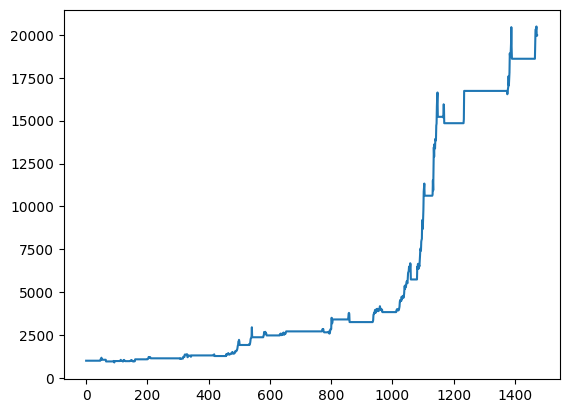

In [176]:
Testing_signals = TradingStrategy_Compounding(output)
to_submit_comp, trade_wise_comp, every_day_comp = Testing_signals.compounding()

In [177]:
to_submit_comp

,datetime,open,high,low,close,volume,signals
0,2018-01-01,13715.65,13818.55,12750.00,13135.00,6970.441076,0
1,2018-01-02,13135.00,14750.00,12890.02,14580.00,16359.347340,0
2,2018-01-03,14576.87,15473.49,14150.00,14749.97,19457.238601,0
3,2018-01-04,14710.00,15280.00,13918.04,14811.00,18783.876561,0
4,2018-01-05,14805.01,17118.13,14600.00,16579.00,22383.657333,0
...,...,...,...,...,...,...,...
1468,2022-01-08,41707.04,42246.37,40501.00,40679.82,27031.900870,0
1469,2022-01-09,40679.82,42300.00,40520.00,41966.99,27291.009660,-1
1470,2022-01-10,41966.99,42786.70,39650.00,41604.58,51064.904360,0
1471,2022-01-11,41604.58,43100.00,41158.99,42755.00,38062.818280,0


In [178]:
trade_wise_comp.head(5)

,entry,exit,duration,trade type,returns
0,46,51,5,long,5.591151
1,64,65,1,long,-9.321319
2,89,93,4,short,2.435550
3,110,115,5,long,0.741688
4,118,127,9,long,-1.359161


In [179]:
every_day_comp

,datetime,portfolio value,quantity,daily_return
0,2018-01-01,1000.000000,0.000000,NaN
1,2018-01-02,1000.000000,0.000000,0.000000
2,2018-01-03,1000.000000,0.000000,0.000000
3,2018-01-04,1000.000000,0.000000,0.000000
4,2018-01-05,1000.000000,0.000000,0.000000
...,...,...,...,...
1468,2022-01-08,20318.587475,0.000000,0.000000
1469,2022-01-09,20318.587475,0.484156,0.000000
1470,2022-01-10,20494.050602,0.484156,0.008636
1471,2022-01-11,19937.067377,0.484156,-0.027178


# Statistical tests for the strategy

## T- Statistic

In [180]:
Sharpe_ratio = Calculate_Parameters.sharpe_ratio(trade_wise_static['returns'])

In [181]:
number_of_years = len(data) // 365
t_statistic = Sharpe_ratio * number_of_years

In [182]:
from scipy.stats import t

def calculate_p_value(t_statistic, degrees_of_freedom):
    p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df=degrees_of_freedom))
    return p_value

degrees_of_freedom=len(data)-1

p_value = calculate_p_value(t_statistic, degrees_of_freedom)
if p_value>0.05:
  print(f'P-Value: {p_value} > 0.05, strategy does not have a strategic importance')
if p_value<0.05:
  print(f'P-Value: {p_value} < 0.05, strategy has a strategic importance')

P-Value: 0.0 < 0.05, strategy has a strategic importance


## Binomial test

In [183]:
benchmark = []
for i in range(len(data)):
    benchmark.append(data['close'][i]*1000/data['close'][0]-1000)

In [184]:
import numpy as np
from scipy.stats import binom_test

# Define the threshold for superiority
threshold = 0.001

# Calculate the number of instances where strategy outperforms benchmark
superiority_count = np.sum(every_day_comp['portfolio value'] - benchmark > threshold)

# Set up the binomial test
num_trials = len(every_day_comp)
p_value = binom_test(superiority_count, num_trials, p=0.5, alternative='greater')

# Print the results
print(f"Superiority count: {superiority_count}")
print(f"P-value: {p_value}")

# Check if the null hypothesis is rejected at a significance level of 0.05
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Strategy returns are consistently better than the benchmark.")
else:
    print("Fail to reject the null hypothesis: No evidence that strategy returns are consistently better than the benchmark.")

Superiority count: 1473
P-value: 0.0
Reject the null hypothesis: Strategy returns are consistently better than the benchmark.


# Results overview

## Results from Static Approach

In [185]:
Static_Approach = TradingStrategy_Static(output)
to_submit_static, trade_wise_static = Static_Approach.static()

+-------------------------+----------+
| Metric                  | Value    |
+=========================+==========+
| Number of closed trades | 31       |
+-------------------------+----------+
| Winning trades          | 22       |
+-------------------------+----------+
| Losing trades           | 9        |
+-------------------------+----------+
| Benchmark returns       | 2248.95  |
+-------------------------+----------+
| Win rate                | 70.97    |
+-------------------------+----------+
| Gross profit            | 3604.01  |
+-------------------------+----------+
| Net profit              | 3557.51  |
+-------------------------+----------+
| Average profit          | 114.76   |
+-------------------------+----------+
| Maximum drawdown        | -9.32    |
+-------------------------+----------+
| Largest win             | 849.76   |
+-------------------------+----------+
| Average win             | 176.55   |
+-------------------------+----------+
| Largest loss           

## Results from Compounding Approach

+-------------------------+-----------+
| Metric                  | Value     |
+=========================+===========+
| Number of closed trades | 31        |
+-------------------------+-----------+
| Winning trades          | 22        |
+-------------------------+-----------+
| Losing trades           | 9         |
+-------------------------+-----------+
| Benchmark returns       | 2248.95   |
+-------------------------+-----------+
| Win rate                | 70.97     |
+-------------------------+-----------+
| Largest win             | 85.13     |
+-------------------------+-----------+
| Average win             | 17.8      |
+-------------------------+-----------+
| Largest loss            | -9.32     |
+-------------------------+-----------+
| Average loss            | -3.48     |
+-------------------------+-----------+
| Maximum holding time    | 48        |
+-------------------------+-----------+
| Average holding period  | 11.29     |
+-------------------------+-----------+


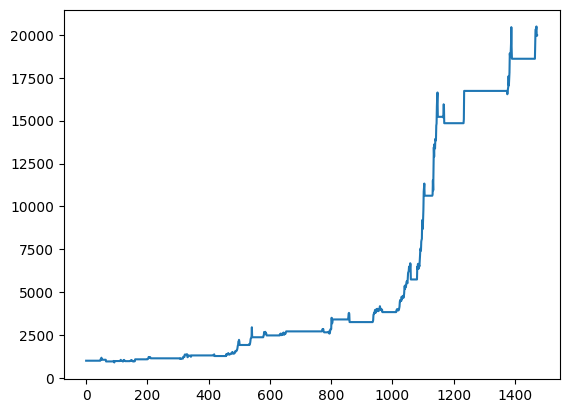

In [186]:
Compounding_Approach = TradingStrategy_Compounding(output)
to_submit_compounding, trade_wise_compounding, every_day_compounding = Compounding_Approach.compounding()

## Interactive trade plot

In [187]:
import plotly.graph_objects as go
import pandas as pd

# Create candlestick chart
fig = go.Figure(data=[go.Candlestick(x=data['datetime'],
                                     open=data['open'],
                                     high=data['high'],
                                     low=data['low'],
                                     close=data['close'],
                                     name='candlestick'
                                     )])

signal_candles_buy = to_submit[to_submit['signals'] == 1]
signal_candles_sell = to_submit[to_submit['signals'] == -1]

# Add text labels for Buy and Sell points
x = np.arange(len(trade_wise_comp))

array = []
for index, row in signal_candles_buy.iterrows():
    a = 0
    for i in x:
        if trade_wise_comp['trade type'][i] == 'long':
            continue
        if trade_wise_comp.exit[i] == index:
            a = 1
            break

    if a == 0:
        continue

    fig.add_trace(go.Scatter(x=[row['datetime']],
                             y=[row['close']],
                             mode='markers',
                             marker=dict(symbol='triangle-down', color='blue', size=15),
                             hovertemplate=f'Exit from Short: {data.datetime[index]} <br>Closing price: {data.close[index]} <br>Profit (%)= {trade_wise_comp.returns[i]} ',  # Text to appear on hover
                             showlegend=False))

array = []
for index, row in signal_candles_buy.iterrows():
    a = 0
    for i in x:
        if trade_wise_comp['trade type'][i] == 'short':
            continue
        if trade_wise_comp.entry[i] == index:
            a = 1
            break

    if a == 0:
        continue

    fig.add_trace(go.Scatter(x=[row['datetime']],
                             y=[row['close']],
                             mode='markers',
                             marker=dict(symbol='triangle-up', color='blue', size=15),
                             hovertemplate=f'Entry into Long: {data.datetime[index]} <br>Closing price: {data.close[index]} <br>Profit (%)= {trade_wise_comp.returns[i]}  ',  # Text to appear on hover
                             showlegend=False))

array = []
for index, row in signal_candles_sell.iterrows():
    a = 0
    for i in x:
        if trade_wise_comp['trade type'][i] == 'long':
            continue
        if trade_wise_comp.entry[i] == index:
            a = 1
            break

    if a == 0:
        continue

    fig.add_trace(go.Scatter(x=[row['datetime']],
                             y=[row['close']],
                             mode='markers',
                             marker=dict(symbol='triangle-down', color='yellow', size=15),
                             hovertemplate=f'Entry into Short: {data.datetime[index]} <br>Closing price: {data.close[index]} <br>Profit (%)= {trade_wise_comp.returns[i]} ',  # Text to appear on hover
                             showlegend=False))

array = []
for index, row in signal_candles_sell.iterrows():
    a = 0
    for i in x:
        if trade_wise_comp['trade type'][i] == 'short':
            continue
        if trade_wise_comp.exit[i] == index:
            a = 1
            break

    if a == 0:
        continue

    fig.add_trace(go.Scatter(x=[row['datetime']],
                             y=[row['close']],
                             mode='markers',
                             marker=dict(symbol='triangle-up', color='yellow', size=15),
                             hovertemplate=f'Exit from Long: {data.datetime[index]} <br>Closing price: {data.close[index]} <br>Profit (%)= {trade_wise_comp.returns[i]}  ',  # Text to appear on hover
                             showlegend=False))

# Customize the layout
fig.update_layout(
    title='Entry positions into trades',
    xaxis_title='Date',
    yaxis_title='Closing Price',
    xaxis_rangeslider_visible=False,
    plot_bgcolor='rgb(17,17,17)',  # Dark background color
    paper_bgcolor='rgb(17,17,17)',
    xaxis=dict(showgrid=False),  # Hide x-axis grid
    yaxis=dict(showgrid=False),
    font=dict(color='white'),     # Font color
    margin=dict(l=10, r=10, t=40, b=10)
)

fig.update_layout(
    legend=dict(
        orientation='h',  # horizontal legend
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Show the plot
fig.show()

#Entry positions into trades. Blue indicates entry into long trades and yellow indicates entry into short trades